# Modeling Pipeline

In [249]:
import numpy as np
import pandas as pd
import time
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import seaborn as sns

In [250]:
useless_list=\
['new_purchase_amount_mean',
 'authorized_purchase_amount_sum',
 'unauthorized_category_2_1.0_mean',
 'authorized_category_2_3.0_sum']

In [251]:
useless_features =\
['card_id',
 'first_active_month',
 'outliers',
 ]

In [252]:
useless_features = useless_features+ useless_list

## Part 1 Training Basic Model With All Data

In [253]:
%%time
df_train = pd.read_csv('train_new_clean.csv')
df_test = pd.read_csv('test_new_clean.csv')

CPU times: user 7.47 s, sys: 164 ms, total: 7.63 s
Wall time: 7.63 s


### Meta Features

In [254]:
meta_train = pd.read_csv('meta_train.csv')
meta_test = pd.read_csv('meta_test.csv')

In [255]:
df_train = df_train.merge(meta_train,on='card_id',how='left')
df_test = df_test.merge(meta_test,on='card_id',how='left')

In [256]:
target = df_train['target']
del df_train['target']

### Feature Engineering: Interactions

In [257]:
for df in [df_train,df_test]:
    df['unauthorized_transactions_count'].fillna(0,inplace= True)
    df['unauthorized_rate'] = df['unauthorized_transactions_count']/ \
    (df['authorized_transactions_count']+df['unauthorized_transactions_count'])
    
for df in [df_train,df_test]:
    df['new_purchase_rate'] = df['new_transactions_count']/ \
    (df['authorized_transactions_count']+df['unauthorized_transactions_count']/(df.authorized_month_lag_min*(-1)+1))
    
for df in [df_train,df_test]:
    df['category_1_diff'] = df['authorized_category_1_mean']-df['new_category_1_mean']
    df['purchase_amount_mean_diff'] = df['authorized_purchase_amount_mean']-df['new_purchase_amount_mean']
    df['installments_max_diff'] = df['authorized_installments_max']-df['new_installments_max']
    df['category_1_diff'] = df['authorized_category_1_mean']-df['new_category_1_mean']
    #df['purchase_amount_max_diff'] = df['authorized_purchase_amount_max']-df['new_purchase_amount_max']    
    #df['purchase_amount_mean_ratio']= df['new_purchase_amount_mean']/df['authorized_purchase_amount_mean']
    #df['purchase_amount_sum_ratio']= df['new_purchase_amount_sum']/df['authorized_purchase_amount_sum']
    #df['category_1_sum_ratio'] = df['new_category_1_sum']/df['authorized_category_1_sum']
    #df['installments_max_ratio'] = df['new_installments_max']/df['authorized_installments_max']
    #df['installments_mean_diff'] = df['authorized_installments_mean']-df['new_installments_mean']
    #df['3lag_purchase_amount_diff'] = df['lag-2_to_0_amount']-df['new_purchase_amount_mean']
    #df['purchase_internal'] = df['authorized_purchase_date_max']-df_train['new_purchase_date_min']
    
    

### Training Basic Model

In [258]:
features = [c for c in df_train.columns if c not in useless_features]
categorical_feats = [c for c in features if 'feature_' in c]

In [259]:
len(features)

184

In [260]:
param = {'objective':'regression',
         'num_leaves': 43,
         'min_data_in_leaf': 40,
         'max_depth': -1,
         'learning_rate': 0.01,
         'lambda_l1':0.17,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':4,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "verbosity": -1,
         "random_state": 4}

In [261]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=233)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval= 500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold 0
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 3.3918	valid_1's rmse: 3.66729
Early stopping, best iteration is:
[575]	training's rmse: 3.36729	valid_1's rmse: 3.66692
fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 3.40659	valid_1's rmse: 3.64043
Early stopping, best iteration is:
[775]	training's rmse: 3.3303	valid_1's rmse: 3.63791
fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 3.39355	valid_1's rmse: 3.66937
Early stopping, best iteration is:
[811]	training's rmse: 3.30816	valid_1's rmse: 3.66623
fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 3.40112	valid_1's rmse: 3.63707
Early stopping, best iteration is:
[872]	training's rmse: 3.29909	valid_1's rmse: 3.63317
fold 4
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 3.39778	valid_1's rmse: 3.65779
[1000]	training's

In [262]:
train_prediction = pd.DataFrame({"card_id":df_train["card_id"].values})
train_prediction["oof_lgb"] = oof
train_prediction.to_csv('single_lightgbm_train.csv',index=False)

In [264]:
# save basic model predictions
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("submission1.csv", index=False)

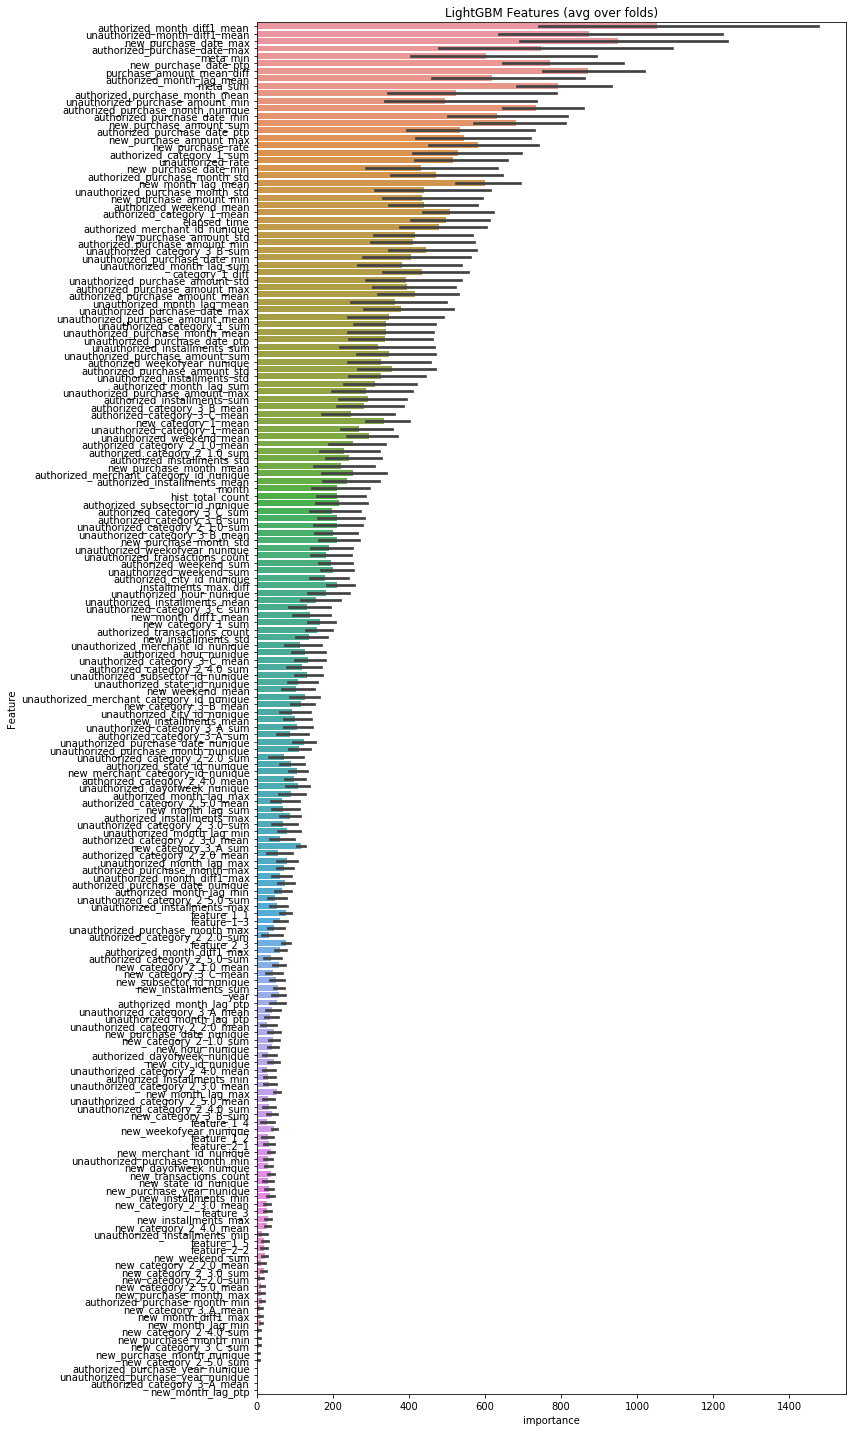

In [265]:
# Feature Importance
plt.figure(figsize=(12,20))
sns.barplot(x="importance",
            y="Feature",
            data = feature_importance_df.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

### Part 2 Training Model Without Outliers

In [272]:
%%time
df_train = pd.read_csv('train_new_clean.csv')
df_test = pd.read_csv('test_new_clean.csv')

CPU times: user 7.62 s, sys: 188 ms, total: 7.81 s
Wall time: 7.81 s


### Meta Features

In [273]:
meta_train = pd.read_csv('meta_train.csv')
meta_test = pd.read_csv('meta_test.csv')

In [274]:
df_train = df_train.merge(meta_train,on='card_id',how='left')
df_test = df_test.merge(meta_test,on='card_id',how='left')

In [275]:
for df in [df_train,df_test]:
    df['unauthorized_transactions_count'].fillna(0,inplace= True)
    df['unauthorized_rate'] = df['unauthorized_transactions_count']/ \
    (df['authorized_transactions_count']+df['unauthorized_transactions_count'])
    
for df in [df_train,df_test]:
    df['new_purchase_rate'] = df['new_transactions_count']/ \
    (df['authorized_transactions_count']+df['unauthorized_transactions_count']/(df.authorized_month_lag_min*(-1)+1))
    
for df in [df_train,df_test]:
    df['category_1_diff'] = df['authorized_category_1_mean']-df['new_category_1_mean']
    df['purchase_amount_mean_diff'] = df['authorized_purchase_amount_mean']-df['new_purchase_amount_mean']
    df['installments_max_diff'] = df['authorized_installments_max']-df['new_installments_max']
    df['category_1_diff'] = df['authorized_category_1_mean']-df['new_category_1_mean']
    #df['installments_mean_diff'] = df['authorized_installments_mean']-df['new_installments_mean']
    #df['3lag_purchase_amount_diff'] = df['lag-2_to_0_amount']-df['new_purchase_amount_mean']
    #df['purchase_internal'] = df['authorized_purchase_date_max']-df_train['new_purchase_date_min']/1000000000
    #df['purchase_amount_max_diff'] = df['authorized_purchase_amount_max']-df['new_purchase_amount_max']
    #df['purchase_amount_mean_ratio']= df['new_purchase_amount_mean']/df['authorized_purchase_amount_mean']
    #df['purchase_amount_sum_ratio']= df['new_purchase_amount_sum']/df['authorized_purchase_amount_sum']
    #df['category_1_sum_ratio'] = df['new_category_1_sum']/df['authorized_category_1_sum']
    #df['installments_max_ratio'] = df['new_installments_max']/df['authorized_installments_max']
    
    

### filtering out outliers & training

In [276]:
df_train_outliers = df_train[df_train['outliers'] == 1]
df_train = df_train[df_train['outliers'] == 0] #filter out outliers
target = df_train['target']
del df_train['target']
del df_train_outliers['target']

In [277]:
features = [c for c in df_train.columns if c not in useless_features]
categorical_feats = [c for c in features if 'feature_' in c]

In [278]:
len(features)

184

In [279]:
param = {'objective':'regression',
         'num_leaves': 43,
         'min_data_in_leaf': 40,
         'max_depth': -1,
         'learning_rate': 0.01,
         'lambda_l1':0.17,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':4,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "verbosity": -1,
         "random_state": 4}

In [280]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2333)
oof = np.zeros(len(df_train))
outliers_oof = np.zeros(len(df_train_outliers))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx],categorical_feature=categorical_feats)#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx],categorical_feature=categorical_feats)#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval= 500, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    outliers_oof += clf.predict(df_train_outliers[features], num_iteration=clf.best_iteration)/folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold 0


/home/ubuntu/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.52717	valid_1's rmse: 1.56447
[1000]	training's rmse: 1.49615	valid_1's rmse: 1.55989
[1500]	training's rmse: 1.47221	valid_1's rmse: 1.55893
[2000]	training's rmse: 1.45058	valid_1's rmse: 1.55835
[2500]	training's rmse: 1.42986	valid_1's rmse: 1.55791
Early stopping, best iteration is:
[2521]	training's rmse: 1.42903	valid_1's rmse: 1.55789
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.53192	valid_1's rmse: 1.54308
[1000]	training's rmse: 1.50085	valid_1's rmse: 1.53953
[1500]	training's rmse: 1.47618	valid_1's rmse: 1.53904
[2000]	training's rmse: 1.45341	valid_1's rmse: 1.53872
Early stopping, best iteration is:
[2100]	training's rmse: 1.44911	valid_1's rmse: 1.53869
fold 2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.52615	valid_1's rmse: 1.56947
[1000]	training's rmse: 1.49527	valid_1's rmse: 1.56474
[1

In [281]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("no_lier_light_gbm_sub.csv", index=False)

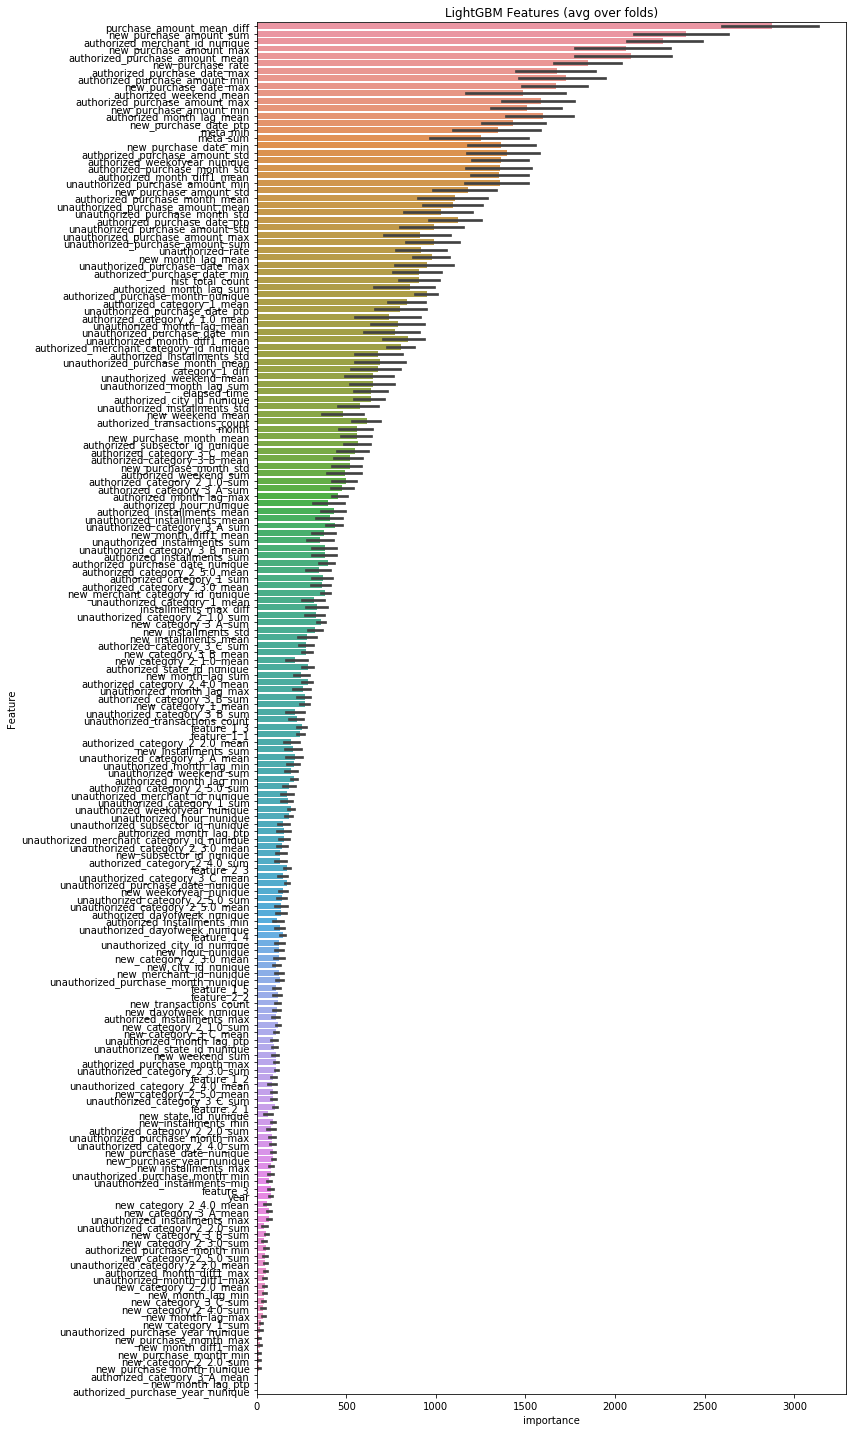

In [282]:
plt.figure(figsize=(12,20))
sns.barplot(x="importance",
            y="Feature",
            data = feature_importance_df.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

## Part 3 Training Model For Outliers Classification

In [283]:
%%time
df_train = pd.read_csv('train_new_clean.csv')
df_test = pd.read_csv('test_new_clean.csv')

CPU times: user 7.29 s, sys: 132 ms, total: 7.42 s
Wall time: 7.42 s


### Meta Features

In [284]:
meta_train = pd.read_csv('meta_train.csv')
meta_test = pd.read_csv('meta_test.csv')

In [285]:
df_train = df_train.merge(meta_train,on='card_id',how='left')
df_test = df_test.merge(meta_test,on='card_id',how='left')

In [286]:
for df in [df_train,df_test]:
    df['unauthorized_transactions_count'].fillna(0,inplace= True)
    df['unauthorized_rate'] = df['unauthorized_transactions_count']/ \
    (df['authorized_transactions_count']+df['unauthorized_transactions_count'])
    
for df in [df_train,df_test]:
    df['new_purchase_rate'] = df['new_transactions_count']/ \
    (df['authorized_transactions_count']+df['unauthorized_transactions_count']/(df.authorized_month_lag_min*(-1)+1))
    
for df in [df_train,df_test]:
    df['category_1_diff'] = df['authorized_category_1_mean']-df['new_category_1_mean']
    df['purchase_amount_mean_diff'] = df['authorized_purchase_amount_mean']-df['new_purchase_amount_mean']
    df['installments_max_diff'] = df['authorized_installments_max']-df['new_installments_max']
    df['category_1_diff'] = df['authorized_category_1_mean']-df['new_category_1_mean']
    #df['installments_mean_diff'] = df['authorized_installments_mean']-df['new_installments_mean']
    #df['3lag_purchase_amount_diff'] = df['lag-2_to_0_amount']-df['new_purchase_amount_mean']
    #df['purchase_internal'] = df['authorized_purchase_date_max']-df_train['new_purchase_date_min']
    #df['purchase_amount_max_diff'] = df['authorized_purchase_amount_max']-df['new_purchase_amount_max']
    #df['purchase_amount_mean_ratio']= df['new_purchase_amount_mean']/df['authorized_purchase_amount_mean']
    #df['purchase_amount_sum_ratio']= df['new_purchase_amount_sum']/df['authorized_purchase_amount_sum']
    #df['category_1_sum_ratio'] = df['new_category_1_sum']/df['authorized_category_1_sum']
    #df['installments_max_ratio'] = df['new_installments_max']/df['authorized_installments_max']
    
    

In [287]:
target = df_train['outliers']
del df_train['outliers']
del df_train['target']

In [288]:
useless_features =\
['card_id',
 'first_active_month',
 'outliers'
 ]

In [289]:
features = [c for c in df_train.columns if c not in useless_features]
categorical_feats = [c for c in features if 'feature_' in c]

In [290]:
len(features)

188

In [291]:
param = {'objective':'binary',
         'num_leaves': 43,
         'min_data_in_leaf': 20,
         'max_depth': -1,
         'learning_rate': 0.01,
         'lambda_l1':0.17,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':4,
         "bagging_fraction": 0.9 ,
         "metric": 'binary_logloss',
         "verbosity": -1,
         "random_state": 4}

In [292]:
%%time
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

start = time.time()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target,oof)))

fold n°0


/home/ubuntu/.local/lib/python3.5/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/.local/lib/python3.5/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[250]	training's binary_logloss: 0.0319862	valid_1's binary_logloss: 0.0447562
[500]	training's binary_logloss: 0.0257965	valid_1's binary_logloss: 0.04429
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0260088	valid_1's binary_logloss: 0.0442821
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's binary_logloss: 0.032094	valid_1's binary_logloss: 0.0435948
[500]	training's binary_logloss: 0.0258477	valid_1's binary_logloss: 0.0431016
[750]	training's binary_logloss: 0.0216841	valid_1's binary_logloss: 0.0431282
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.0248584	valid_1's binary_logloss: 0.0430911
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's binary_logloss: 0.0323459	valid_1's binary_logloss: 0.0425136
[500]	training's binary_logloss: 0.0260812	valid_1's binary_logloss: 0.0420899
[750]	training'

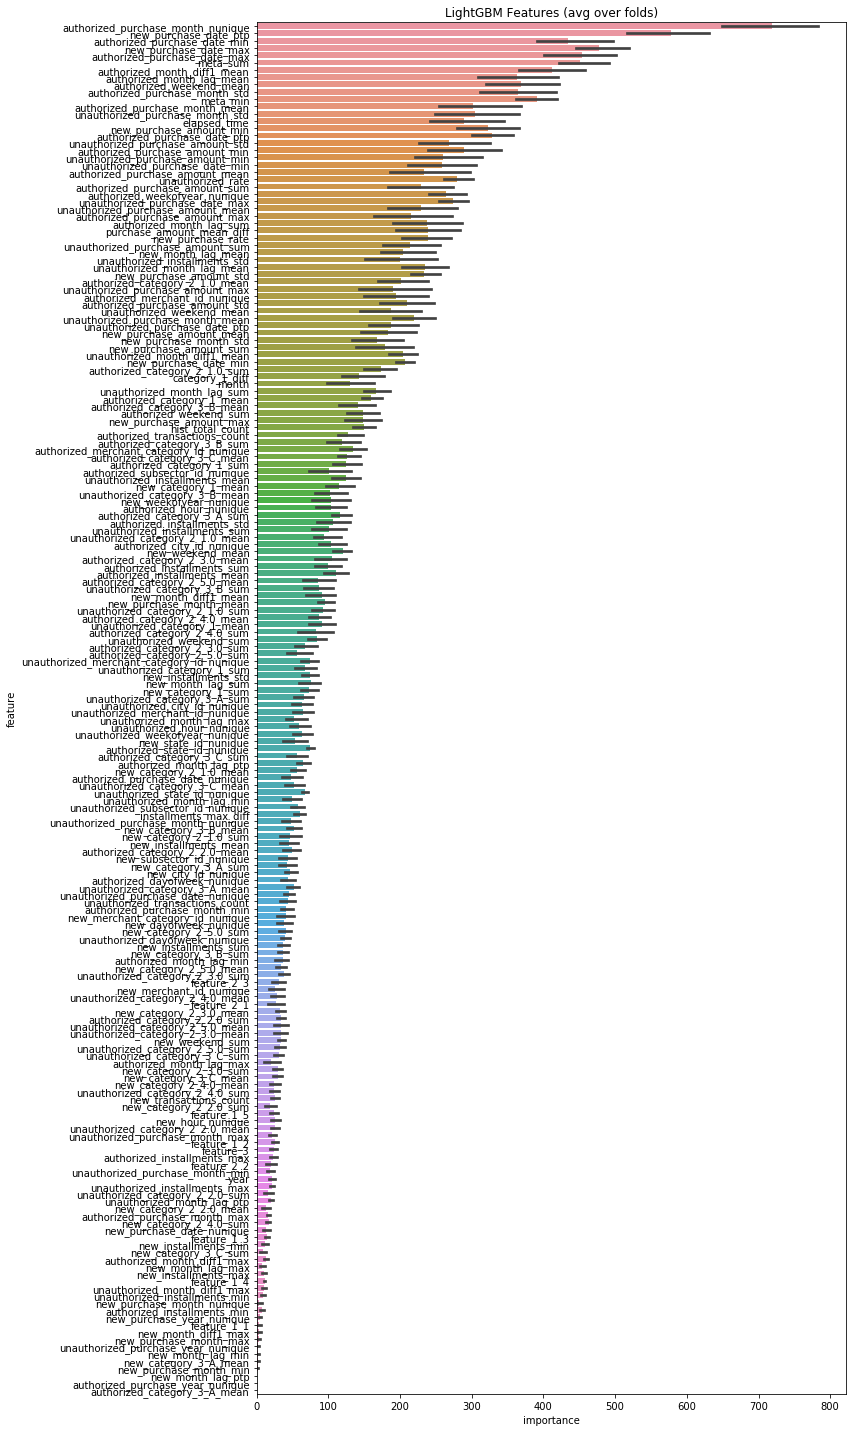

In [296]:
###当一个feature有多个值时(这里有5个fold所以有5个值), sns.barplot 会给出mean/max/min
plt.figure(figsize=(12,20))
sns.barplot(x="importance",
            y="feature",
            data = feature_importance_df.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [297]:
### 'target' is the probability of whether an observation is an outlier
df_outlier_prob = pd.DataFrame({"card_id":df_test["card_id"].values})
df_outlier_prob["target"] = predictions

In [298]:
df_outlier_prob.columns = ['card_id','outlier_prob']
df_outlier_prob.to_csv('df_outlier_prob_test.csv',index=False)

## Part 4 Post Processing: Combining Submission
So far so good !
We now have three dataset:

1. Best Submission
2. Prediction Using Model Without Outliers
3. Probability of Outliers In Test set


In [299]:
df_outlier_prob = pd.read_csv('df_outlier_prob_test.csv')

In [300]:
model_without_outliers = pd.read_csv('no_lier_light_gbm_sub.csv')

In [301]:
best_submission = pd.read_csv('submission.csv')

In [302]:
best_submission = pd.read_csv('stacking_prediction.csv')

In [303]:
model_without_outliers['target'] = \
df_outlier_prob['outlier_prob']*(-33.21928)+(1-df_outlier_prob['outlier_prob'])*model_without_outliers['target']

In [304]:
model_without_outliers.to_csv("combining_submission.csv", index=False)